<a href="https://colab.research.google.com/github/KarelZe/thesis/blob/baseline/notebooks/3.0-mb-feature_engineering_baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install catboost==1.1
!pip install gcsfs==2022.10.0
!pip install ipywidgets==8.0.2
!pip install numpy==1.23.4
!pip install pandas==1.5.1
!pip install optuna==3.0.3
!pip install scikit-learn==1.1.3
!pip install seaborn==0.12.1
!pip install wandb==0.13.4

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.2 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
ERROR: Could not find a version that satisfies the requirement numpy==1.23.4 (from versions: 1.3.0, 1.4.1, 1.5.0, 1.5.1, 1.6.0, 1.6.1, 1.6.2, 1.7.0, 1.7.1, 1.7.2, 1.8.0, 1.8.1, 1.8.2, 1.9.0, 1.9.1, 1.9.2, 1.9.3, 1.10.0.post2, 1.10.1, 1.10.2, 1.10.4, 1.11.0, 1.11.1, 1.11.2, 1.11.3, 1.12.0, 1.12.1, 1.13.0rc1, 1.13.0rc2, 1.13.0, 1.13.1, 1.13.3, 1.14.0rc1, 1.14.0, 1.14.1, 1.14.2, 1.14.3, 1.14.4, 1.14.5, 1.14.6, 1.15.0rc1, 1.15.0rc2, 1.15.0, 1.15.1, 1.15.2, 1.15.3, 1.15.4, 1.16.0rc1, 1.16.0rc2, 1.16.0, 1.16.1, 1.16.2, 1.16.3, 1.16.4, 1.16.5, 1.16.6, 1.17.0rc1, 1.17.0rc2, 1.17.0, 1.17.1, 1.17.2, 1.17.3, 1.17.4, 1.17.5, 1.18.0rc1, 1.18.0, 1.18.

In [ ]:
import os
import random

from catboost import CatBoostClassifier, MetricVisualizer

import gcsfs
import google.auth
from google.colab import auth, output

import numpy as np
import pandas as pd
import optuna
from optuna.integration.wandb import WeightsAndBiasesCallback

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score

import seaborn as sns

from tqdm.notebook import tqdm
import wandb

In [ ]:
# connect to weights and biases
run = wandb.init(project="thesis", job_type="dataset-creation", entity="fbv")
dataset = wandb.Artifact(name='train_val_test', type="preprocessed_data")

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 

··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [ ]:
# connect to google cloud storage
auth.authenticate_user()
credentials, _ = google.auth.default()
fs = gcsfs.GCSFileSystem(project="thesis", token=credentials)
fs_prefix = "gs://"

In [ ]:
output.enable_custom_widget_manager()

In [ ]:
# set fixed seed
def seed_everything(seed): 
  """ 
  Seeds basic parameters for reproducibility of results 
  """ 
  os.environ["PYTHONHASHSEED"] = str(seed) 
  random.seed(seed)

seed = 42
seed_everything(seed)

In [ ]:
train = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/preprocessed/train_set_60.parquet")
val = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/preprocessed/val_set_20.parquet")
test = pd.read_parquet(f"gs://thesis-bucket-option-trade-classification/data/preprocessed/test_set_20.parquet")

In [ ]:
train.head(10)

,UNDERLYING_SYMBOL,QUOTE_DATETIME,SEQUENCE_NUMBER,ROOT,EXPIRATION,STRK_PRC,OPTION_TYPE,TRADE_SIZE,TRADE_PRICE,BEST_BID,...,bid_ex,bid_size_ex,ask_size_ex,price_all_lead,price_all_lag,optionid,day_vol,price_ex_lead,price_ex_lag,buy_sell
0,BRCD,2005-05-02 09:30:02,72515,YNU,2006-01-21,2.5,C,10,2.05,1.90,...,1.90,131.0,20.0,1.90,1.90,21060388.0,10.0,1.90,2.10,1
1,SYMC,2005-05-02 09:30:03,65366,SYQ,2005-06-18,15.0,C,10,3.90,3.60,...,NaN,NaN,NaN,4.00,4.00,31624184.0,10.0,4.60,4.00,1
2,SPY,2005-05-02 09:30:03,65373,SWG,2005-05-21,105.0,C,50,11.20,11.10,...,11.10,300.0,300.0,11.80,11.00,31620976.0,50.0,11.90,11.00,-1
3,ADRX,2005-05-02 09:30:03,79195,QAX,2005-06-18,25.0,C,10,0.20,0.00,...,0.00,0.0,86.0,0.15,0.15,31560072.0,10.0,0.15,0.15,1
4,ORCL,2005-05-02 09:30:03,95870,ORQ,2005-12-17,14.0,C,15,0.25,0.30,...,0.25,3356.0,399.0,0.35,0.35,25240212.0,17.0,0.35,0.35,-1
5,YHOO,2005-05-02 09:30:03,73595,YHQ,2005-10-22,35.0,P,26,3.00,2.95,...,2.90,1133.0,256.0,3.10,3.40,24020608.0,46.0,3.10,3.40,-1
6,MATK,2005-05-02 09:30:03,80182,KQT,2005-09-17,65.0,C,2,0.55,0.30,...,0.30,56.0,10.0,0.45,0.45,23989792.0,2.0,0.65,0.45,1
7,VTSS,2005-05-02 09:30:04,80469,VQT,2005-10-22,5.0,P,10,2.75,2.70,...,2.70,10.0,52.0,2.90,2.90,24019950.0,40.0,2.90,2.90,-1
8,ADRX,2005-05-02 09:30:04,80342,QAX,2005-09-17,25.0,C,1,0.60,0.45,...,0.45,94.0,25.0,0.55,0.50,23983374.0,11.0,0.65,0.50,1
9,IVGN,2005-05-02 09:30:04,97063,IUV,2005-08-20,65.0,C,10,11.00,0.00,...,NaN,NaN,NaN,13.80,9.90,23797976.0,10.0,13.80,9.90,1


In [ ]:
# randomly sample frac of rows
frac = 0.02

train = train.sample(frac=frac, random_state=seed)
val = val.sample(frac=frac, random_state=seed)
test = test.sample(frac=frac, random_state=seed)

# unify for common preprocessing
X = pd.concat([train, val, test])

In [ ]:
# calculate days to maturity
X['time_to_maturity'] = (X['EXPIRATION'] - X['QUOTE_DATETIME']).dt.days

In [ ]:
# apply positional encoding to dates
X["date_month_sin"] = np.sin(2 * np.pi * X['QUOTE_DATETIME'].dt.year / 12)
X["date_month_cos"] = np.cos(2 * np.pi * X['QUOTE_DATETIME'].dt.year / 12)

# add year
X["date_year"] = (X['QUOTE_DATETIME'].dt.year - 2005) / (2017-2005) 
# # scaling to range starting at zero up to one
# data["yy"] = data.apply(
#     lambda x: (x.astype(float) - min(x)) / (max(x) - min(x)), axis=0
# )["yy"]

date_columns = ["date_month_sin", "date_month_cos", "date_year"]

In [ ]:
X.dtypes

UNDERLYING_SYMBOL            object
QUOTE_DATETIME       datetime64[ns]
SEQUENCE_NUMBER               int64
ROOT                         object
EXPIRATION           datetime64[ns]
STRK_PRC                    float32
OPTION_TYPE                category
TRADE_SIZE                    int64
TRADE_PRICE                 float32
BEST_BID                    float32
BEST_ASK                    float32
order_id                      int64
ask_ex                      float32
bid_ex                      float32
bid_size_ex                 float32
ask_size_ex                 float32
price_all_lead              float32
price_all_lag               float32
optionid                    float32
day_vol                     float32
price_ex_lead               float32
price_ex_lag                float32
buy_sell                       int8
time_to_maturity              int64
date_month_sin              float64
date_month_cos              float64
date_year                   float64
dtype: object

In [ ]:
# remove problematic features -> see notebook on aversarial validation
X = X.drop(["SEQUENCE_NUMBER", "order_id", "optionid", "EXPIRATION", "QUOTE_DATETIME", "ROOT"], axis=1)

In [ ]:
# isolate target
y = X[["buy_sell"]]
X = X.drop(["buy_sell"], axis=1)

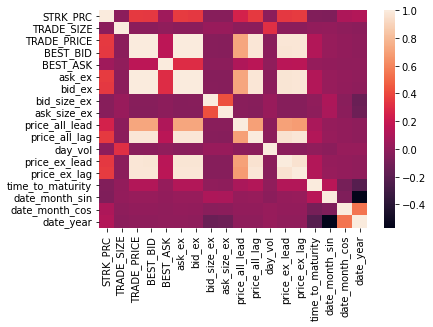

In [ ]:
corr = X.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values)

In [ ]:
# Midspread
mid = 0.5 * (X['ask_ex'] + X['bid_ex'])
X['mid_ex'] = mid

In [ ]:
# Absolute distance from mid
X['abs_mid_ex'] = X['TRADE_PRICE'] - mid

In [ ]:
# Degree how much Trade size is filled
X['rel_bid_size_ex'] = X['TRADE_SIZE'] / X['bid_size_ex']
X['rel_ask_size_ex'] = X['TRADE_SIZE'] / X['ask_size_ex']

In [ ]:
# Calculate sign change from trade
tt = np.where(X['TRADE_PRICE'] > X['price_ex_lead'], 1.0, -1.0)
X['sgn_chg_ex_lead'] = tt

In [ ]:
# select categorical e. g., option type and strings e. g., ticker
cat_columns = X.select_dtypes(include=['category', 'object']).columns.tolist()
print(cat_columns)

# binarize categorical similar to Borisov et al.
X[cat_columns] = X[cat_columns].apply(lambda x : pd.factorize(x)[0])

['UNDERLYING_SYMBOL', 'OPTION_TYPE']


In [ ]:
# treat inf as nan
X.replace([np.inf, -np.inf], np.nan, inplace=True)

In [ ]:
# Fill NaN with 0
# Do not fill, let CatBoost Handle NaNs
# X = X.fillna(0)

In [ ]:
# separate again for training scaling
X_train = X.loc[train.index, :]
X_val = X.loc[val.index, :]
X_test = X.loc[test.index, :]

y_train = y.loc[train.index, :]
y_val = y.loc[val.index, :]
y_test = y.loc[test.index, :]


In [ ]:
# Standardize numerical values
num_columns = X_train.select_dtypes(include=[np.number]).columns.tolist()
num_columns = [x for x in num_columns if x not in cat_columns]
num_columns = [x for x in num_columns if x not in date_columns]
scaler = StandardScaler()

X_train[num_columns] = scaler.fit_transform(X_train[num_columns])
X_val[num_columns] = scaler.transform(X_val[num_columns])
X_test[num_columns] = scaler.transform(X_test[num_columns])

In [ ]:
# Train gradient boosting model
model = CatBoostClassifier(max_depth=8, task_type="GPU", random_state=seed, 
                           logging_level= "Silent", cat_features=cat_columns, 
                           od_type= "Iter", grow_policy="Depthwise")
model.fit(X_train, y_train, eval_set=(X_val,y_val), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

In [ ]:
acc_train = model.score(X_train, y_train)
acc_val = model.score(X_val, y_val)
acc_test = model.score(X_test, y_test)

print(f"Accuracy (train): {acc_train}, (val) {acc_val}, and (test) {acc_test}")

Accuracy (train): 0.8526847557058006, (val) 0.7085863079088567, and (test) 0.6748511596929334


In [ ]:
# Obtain feature importances
ranks = sorted(list(zip(X.columns, model.feature_importances_)), 
               key=lambda x: x[1], reverse=True) 
for feature, score in ranks: 
  print(f"{feature:10} : {score:0.4f}")

ask_size_ex : 34.1995
bid_size_ex : 27.5062
abs_mid_ex : 19.4767
rel_bid_size_ex : 5.2702
day_vol    : 4.3461
rel_ask_size_ex : 2.9701
TRADE_SIZE : 2.1874
ask_ex     : 0.8219
BEST_BID   : 0.5341
date_month_sin : 0.4454
date_year  : 0.3927
time_to_maturity : 0.3715
BEST_ASK   : 0.3002
STRK_PRC   : 0.2630
UNDERLYING_SYMBOL : 0.2347
bid_ex     : 0.2084
date_month_cos : 0.1063
price_all_lead : 0.1046
mid_ex     : 0.0958
TRADE_PRICE : 0.0708
price_ex_lead : 0.0491
sgn_chg_ex_lead : 0.0185
price_all_lag : 0.0152
OPTION_TYPE : 0.0082
price_ex_lag : 0.0031


## CatBoost Baseline 🐈‍⬛

### Hyperparameter Search Baseline🗃️

In [ ]:
def objective(trial:optuna.Trial):
    # See docs for recommendations on tuning hyperparameters
    #  https://catboost.ai/en/docs/concepts/parameter-tuning
    iterations = trial.suggest_int("iterations", 10, 1000, log=False)
    learning_rate = trial.suggest_float("learning_rate", 0.005, 1, log=True)
    # random_strength = trial.suggest_float("random_strength", 1e-9, 10, log=True)
    depth = trial.suggest_int("depth", 1, 8, log=False)
    loss_function = trial.suggest_categorical("loss_function", ["Logloss"])
    grow_policy = trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise"])
    params = {
          "iterations": iterations,
          "depth": depth,
          "grow_policy": grow_policy,
          "learning_rate": learning_rate,
          # "random_strength": random_strength,
          "loss_function": loss_function,
          "od_type": "Iter",
          "logging_level": "Silent",
          "task_type": "GPU"}  

    model = CatBoostClassifier(**params)

    model.fit(
          X_train,
          y_train,
        )

    y_pred = model.predict(X_val, prediction_type='Class')
    return accuracy_score(y_val, y_pred)


In [ ]:
wandb_kwargs = {"project": "thesis"}
wandbc = WeightsAndBiasesCallback(wandb_kwargs=wandb_kwargs)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: ExperimentalWarning: WeightsAndBiasesCallback is experimental (supported from v2.9.0). The interface can change in the future.
  


In [ ]:
# Implement hyperparameter search
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=seed), study_name="baseline_gbm")
study.optimize(objective, n_trials=2, callbacks=[wandbc])

[I 2022-11-01 14:43:40,644] A new study created in memory with name: baseline_gbm
[I 2022-11-01 14:44:19,517] Trial 0 finished with value: 0.7360473628007584 and parameters: {'iterations': 381, 'lr': 0.7701798297509621, 'depth': 6, 'loss': 'Logloss', 'grow_policy': 'SymmetricTree'}. Best is trial 0 with value: 0.7360473628007584.
[I 2022-11-01 14:44:48,113] Trial 1 finished with value: 0.7070839458409205 and parameters: {'iterations': 164, 'lr': 0.006801773068059042, 'depth': 7, 'loss': 'Logloss', 'grow_policy': 'Depthwise'}. Best is trial 0 with value: 0.7360473628007584.


In [ ]:
ax_history = optuna.visualization.matplotlib.plot_optimization_history(study)
ax_param_importance = optuna.visualization.matplotlib.plot_param_importances(study)
fig_contour = optuna.visualization.matplotlib.plot_contour(
    study, ["iterations", "depth", "grow_policy", "learning_rate"]
)

In [ ]:
print(f"Number of finished trials: {len(study.trials)}")

trial = study.best_trial

print(f"Best trial: {trial}")

print(f"Value: {trial.value}")

print("Params:")
for key, value in trial.params.items():
    print(f"{key}: {value}")

Number of finished trials: 50
Best trial: FrozenTrial(number=44, values=[0.7470570902671329], datetime_start=datetime.datetime(2022, 11, 1, 14, 23, 46, 726304), datetime_complete=datetime.datetime(2022, 11, 1, 14, 25, 16, 546737), params={'iterations': 610, 'lr': 0.3845969764559549, 'depth': 8, 'loss': 'Logloss', 'grow_policy': 'Depthwise'}, distributions={'iterations': IntDistribution(high=1000, log=False, low=10, step=1), 'lr': FloatDistribution(high=1.0, log=True, low=0.005, step=None), 'depth': IntDistribution(high=8, log=False, low=1, step=1), 'loss': CategoricalDistribution(choices=('Logloss',)), 'grow_policy': CategoricalDistribution(choices=('SymmetricTree', 'Depthwise'))}, user_attrs={}, system_attrs={}, intermediate_values={}, trial_id=44, state=TrialState.COMPLETE, value=None)
Value: 0.7470570902671329
Params:
iterations: 610
lr: 0.3845969764559549
depth: 8
loss: Logloss
grow_policy: Depthwise


In [ ]:
static_params = {"od_type": "Iter",
          "logging_level": "Silent",
          "task_type": "GPU"} 

params = {**static_params, **trial.params}
print(params)

{'od_type': 'Iter', 'logging_level': 'Silent', 'task_type': 'GPU', 'iterations': 610, 'lr': 0.3845969764559549, 'depth': 8, 'loss': 'Logloss', 'grow_policy': 'Depthwise'}


In [ ]:
model = CatBoostClassifier(**params)
model.fit(X_train,y_train, plot=True)

In [ ]:
w = catboost.MetricVisualizer('/', subdirs=True)
w.start()

In [ ]:
acc_train = model.score(X_train, y_train)
acc_val = model.score(X_val, y_val)
acc_test = model.score(X_test, y_test)

print(f"Accuracy (train): {acc_train}, (val) {acc_val}, and (test) {acc_test}")

Accuracy (train): 0.8968277199298414, (val) 0.7453677847640287, and (test) 0.7065052279676189


### Robustness Baseline🥊

In [ ]:
# Copy unscaled columns
X_print = test.copy()

# add baseline results
X_print["rule"] = "Baseline"
X_print["buy_sell_predicted"] = model.predict(X_test)

# prepare columns for printing
X_print["ttm"] = (X_print['EXPIRATION'] - X_print['QUOTE_DATETIME']).dt.months
X_print["year"] = X_print['QUOTE_DATETIME'].dt.year

bins_tradesize = [0, 1, 3, 5, 11, np.inf]
X_print["TRADE_SIZE_binned"] = pd.cut(X_print["TRADE_SIZE"], bins_tradesize)

bins_years = [2005, 2007, 2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017]
X_print["year_binned"] = pd.cut(X_print["year"], bins_years)

bins_ttm = [0, 1, 2, 3, 6, 12, np.inf]
X_print["ttm_binned"] = pd.cut(X_print["ttm"], bins_ttm)

# TODO: Security type
# TODO: Moneyness
# TODO: time from previous trade; same underlying or any?

In [ ]:
def check_robustness(criterion: str="year_binned") -> pd.DataFrame:
    """
    Check robustness of rules by calculating the accuracy for a given
    criterion and rules.

    Example:
    rule	GBM	Quote Rule (ISE)
    trade_size_binned		
    (0.0, 1.0]	0.493827	0.494118
    (1.0, 3.0]	0.500000	0.466667
    (3.0, 5.0]	0.578947	0.494118
    (5.0, 11.0]	0.422680	0.465909
    (11.0, inf]	0.500000	0.571429

    Args:
        criterion (str, optional): criterion to check robustness for. 
        Defaults to "year_binned".

    Returns:
        pd.DataFrame: DataFrame with accuracy of rules. Rule in columns and 
        criterion values in rows.
    """
    results = (
        df.groupby(["rule", criterion])[["buy_sell", "buy_sell_predicted"]]
        .apply(lambda x: accuracy_score(x["buy_sell"], x["buy_sell_predicted"]))
        .unstack(level=0)
    )
    return results

In [ ]:
check_robustness("years_binned")

In [ ]:
check_robustness("OPTION_TYPE")

In [ ]:
check_robustness("TRADE_SIZE_binned")

In [ ]:
check_robustness("ttm_binned")

In [ ]:
# TODO: print some metrics

# cv_dataset = Pool(data=cv_data,
#                   label=labels,
#                   cat_features=cat_features)

# params = {"iterations": 100,
#           "depth": 2,
#           "loss_function": "Logloss",
#           "verbose": False}

# scores = cv(cv_dataset,
#             params,
#             fold_count=2, 
#             plot="True")

## Classical rules

In [ ]:
df.head().T

,34736684,34736685,34736686,34736687,34736688
UNDERLYING_SYMBOL,LINE,LINE,AMZN,TLT,TLT
QUOTE_DATETIME,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00
SEQUENCE_NUMBER,74466,67183330,8588013,7331304,7331305
ROOT,LINE,LINE,AMZN,TLT,TLT
EXPIRATION,2015-04-17 00:00:00,2015-04-17 00:00:00,2015-02-20 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00
STRK_PRC,9.0,18.0,390.0,124.0,126.0
OPTION_TYPE,C,C,C,P,P
TRADE_SIZE,5,5,1,20,20
TRADE_PRICE,2.14,0.04,1.42,0.01,0.18
BEST_BID,1.8,0.0,0.0,0.0,0.05


In [ ]:
# test if if a lead price is different from the trade price?
sum = (df['TRADE_PRICE'] == df['price_ex_lead']).sum()
print(sum)

0


In [ ]:
# quote rule
mid = 0.5 * (df['ask_ex'] + df['bid_ex'])
qr = np.where(df['TRADE_PRICE'] > mid, 1, np.where(df['TRADE_PRICE'] < mid, -1, np.nan))
df['pred_quote_rule'] = qr

In [ ]:
sum = (df['TRADE_PRICE'] == mid).sum()
print(sum)

632780


In [ ]:
# depth rule p. 14
dr = np.where((df['TRADE_PRICE'] == mid) & (df['ask_size_ex'] > df['bid_size_ex']),1,np.where((df['TRADE_PRICE'] == mid) & (df['ask_size_ex'] < df['bid_size_ex']),-1,np.nan))
df['pred_depth_rule'] = dr

In [ ]:
# tick rule
# FIXME: Disqus with Grauer et al what is used in table 9 ISE or all?
tt = np.where(df['TRADE_PRICE'] > df['price_ex_lead'], 1.0, -1.0)
df['pred_tick_test'] = tt

In [ ]:
# main idea of our new “trade size rule” is that when the trade size matches exactly either the bid or ask quote size, it is likely that the quote came from a customer, the market maker found it attractive and, therefore, decided to fill it completely.
# we propose to classify trades for which the trade size is equal to the quoted bid size as customer buys and those with a trade size equal to the ask size as customer sells.

ts_eq_bid = (df['TRADE_SIZE'] == df['bid_size_ex'])
ts_eq_ask = (df['TRADE_SIZE'] == df['ask_size_ex'])

df['pred_trade_size_quote_rule'] = np.where(ts_eq_bid,1.0, np.where(ts_eq_ask,-1.0, qr))
df['pred_trade_size_tick_test'] = np.where(ts_eq_bid,1.0, np.where(ts_eq_ask,-1.0, tt))

In [ ]:
df['pred_trade_size_depth_rule'] = np.where(ts_eq_bid,1.0, np.where(ts_eq_ask,-1.0, dr))

In [ ]:
# reverse tick rule
df['pred_rev_tick_test'] = np.where(df['TRADE_PRICE'] > df['price_all_lag'], 1.0, -1.0)

In [ ]:
df.head().T

,34736684,34736685,34736686,34736687,34736688
UNDERLYING_SYMBOL,LINE,LINE,AMZN,TLT,TLT
QUOTE_DATETIME,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00,2015-01-02 09:30:00
SEQUENCE_NUMBER,74466,67183330,8588013,7331304,7331305
ROOT,LINE,LINE,AMZN,TLT,TLT
EXPIRATION,2015-04-17 00:00:00,2015-04-17 00:00:00,2015-02-20 00:00:00,2015-01-02 00:00:00,2015-01-02 00:00:00
STRK_PRC,9.0,18.0,390.0,124.0,126.0
OPTION_TYPE,C,C,C,P,P
TRADE_SIZE,5,5,1,20,20
TRADE_PRICE,2.14,0.04,1.42,0.01,0.18
BEST_BID,1.8,0.0,0.0,0.0,0.05


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_quote_rule_random = df['pred_quote_rule'].applymap(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_quote_rule_random)
print(f"{acc:.3%}")

56.073%


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_trade_size_quote_rule_random = df['pred_trade_size_quote_rule'].applymap(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_trade_size_quote_rule_random)
print(f"{acc:.3%}")

65.387%


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_depth_rule_random = df['pred_depth_rule'].map(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_depth_rule_random)
print(f"{acc:.3%}")

51.728%


In [ ]:
# Discuss with C. Grauer how results were calculated in table 9. Assign randomly (table 3) (?)
pred_trade_size_depth_rule_random = df['pred_trade_size_depth_rule'].map(lambda l: l if not np.isnan(l) else np.random.choice([-1, 1]))

acc = accuracy_score(df['buy_sell'], pred_trade_size_depth_rule_random)
print(f"{acc:.3%}")

56.629%


In [ ]:
acc = accuracy_score(df['buy_sell'], df['pred_trade_size_tick_test'])
print(f"{acc:.3%}")

54.617%


In [ ]:
acc = accuracy_score(df['buy_sell'], df['pred_tick_test'])
print(f"{acc:.3%}")

49.181%


In [ ]:
acc = accuracy_score(df['buy_sell'], df['pred_rev_tick_test'])
print(f"{acc:.3%}")

53.864%
